In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("HOST", "localhost")
database = "meneame"

def get_engine():
    return create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

In [3]:
def get_data(news_ids=None, category=None):
    engine = get_engine()
    
    if news_ids:
        query = """
            SELECT news_id, clicks, comments, karma, positive_votes, anonymous_votes, negative_votes
            FROM news_info_table
            WHERE news_id IN ({})
        """.format(','.join(map(str, news_ids)))
    elif category:
        query = """
            SELECT c.category, 
                   AVG(n.clicks) AS clicks, 
                   AVG(n.comments) AS comments, 
                   AVG(n.karma) AS karma,
                   AVG(n.positive_votes) AS positive_votes, 
                   AVG(n.anonymous_votes) AS anonymous_votes,
                   AVG(n.negative_votes) AS negative_votes
            FROM news_info_table n
            JOIN category_table c ON n.category_id = c.category_id
            WHERE c.category = '{}'
            GROUP BY c.category;
        """.format(category)
    else:
        raise ValueError("Debe proporcionar news_ids o una categoría.")
    
    return pd.read_sql(query, engine)

def get_max_values():
    engine = get_engine()
    query = """
        SELECT MAX(clicks) AS clicks, MAX(comments) AS comments, MAX(karma) AS karma,
               MAX(positive_votes) AS positive_votes, MAX(anonymous_votes) AS anonymous_votes,
               MAX(negative_votes) AS negative_votes
        FROM news_info_table
    """
    return pd.read_sql(query, engine).iloc[0]

def normalize_values(values, max_values, variables):
    return [val / max_values[var] if max_values[var] > 0 else 0 for val, var in zip(values, variables)]

def plot_comparison(data1, label1, data2, label2, variables):
    angles = np.linspace(0, 2 * np.pi, len(variables), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, data1 + [data1[0]], linewidth=2, linestyle='solid', label=label1)
    ax.plot(angles, data2 + [data2[0]], linewidth=2, linestyle='solid', label=label2)
    ax.fill(angles, data1 + [data1[0]], alpha=0.25)
    ax.fill(angles, data2 + [data2[0]], alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(variables)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

def comparar(entidad1, entidad2, tipo='noticia'):
    max_values = get_max_values()
    variables = ["clicks", "comments", "karma", "positive_votes", "anonymous_votes", "negative_votes"]

    if tipo == 'noticia':
        df = get_data(news_ids=[entidad1, entidad2])

        if df.empty:
            raise ValueError(f"No se encontraron datos para los news_id: {entidad1}, {entidad2}")

        noticia1 = df[df['news_id'] == entidad1]
        noticia2 = df[df['news_id'] == entidad2]

        if noticia1.empty or noticia2.empty:
            raise ValueError(f"No se encontró información para alguna de las noticias: {entidad1}, {entidad2}")

        data1 = normalize_values(noticia1.iloc[0][variables], max_values, variables)
        data2 = normalize_values(noticia2.iloc[0][variables], max_values, variables)

        plot_comparison(data1, f'Noticia {entidad1}', data2, f'Noticia {entidad2}', variables)

    elif tipo == 'categoria':
        df1 = get_data(category=entidad1)
        df2 = get_data(category=entidad2)

        if df1.empty or df2.empty:
            raise ValueError("Una de las categorías no tiene datos disponibles.")

        data1 = normalize_values(df1.iloc[0][variables], max_values, variables)
        data2 = normalize_values(df2.iloc[0][variables], max_values, variables)

        plot_comparison(data1, f'Categoría {entidad1}', data2, f'Categoría {entidad2}', variables)
    
    else:
        raise ValueError("El tipo debe ser 'noticia' o 'categoria'.")


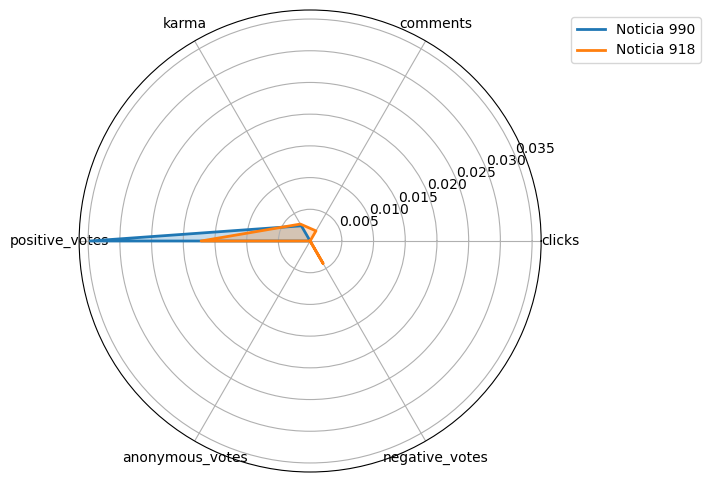

In [4]:
# Ejemplo de uso:
# Comparar dos noticias por ID
comparar(990, 918, tipo="noticia")

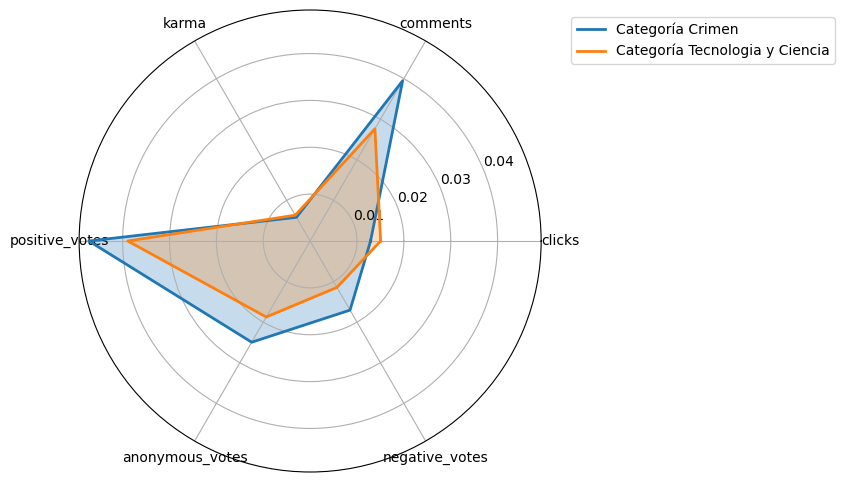

In [5]:
# Comparar dos categorías por nombre
comparar("Crimen", "Tecnologia y Ciencia", tipo="categoria")

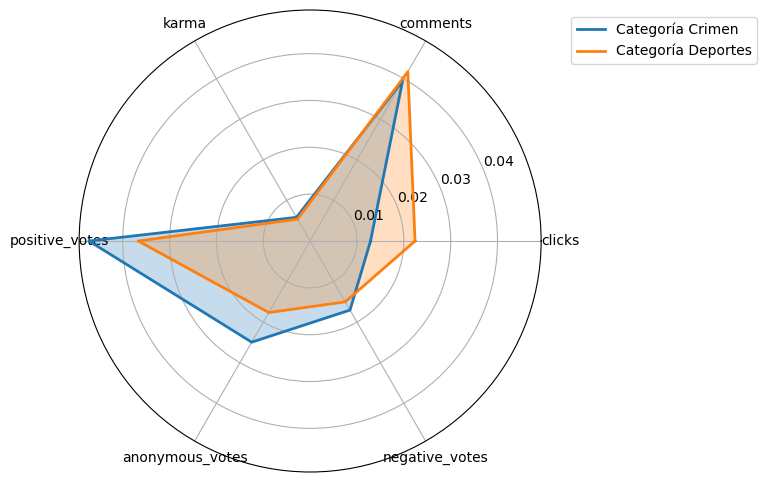

In [6]:
comparar("Crimen", "Deportes", tipo="categoria")